# Extraction des données

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from collections import defaultdict

## Importation et traitement des données par mois pour l'année 2022 (test):

# Chemin vers le fichier
#file_path = "/content/Ventes_auto_mensuelles_2023-10mois-.xlsx"
file_path = "/content/01-01-ADEME_full.xlsx"

# Charger les données
df = pd.read_excel(file_path)


# Colonnes nécessaires
colonnes_utiles = [
    'DATE', 'Modele', 'Energie', 'Marque',
    'Prix_vehic', 'Carrosserie',
    'BONUS_MALUS', 'BONUS_MALUS_BAREME', 'VOLUME'
]

# Supprimer les lignes avec valeurs manquantes
df_clean = df.dropna(subset=colonnes_utiles).copy()

# Calcul du BONUS avec le bon signe
bonus_type = df_clean['BONUS_MALUS'].astype(str).str.lower().to_numpy()
bareme = df_clean['BONUS_MALUS_BAREME'].astype(float).to_numpy()
df_clean['BONUS'] = np.array([
    abs(b) if 'bonus' in s else -abs(b)
    for s, b in zip(bonus_type, bareme)
])

# Création d'un identifiant unique pour chaque configuration de modèle
df_clean['ID_MODELE'] = df_clean.apply(
    lambda row: f"{row['Modele']}|{row['Energie']}|{row['Marque']}|{row['Prix_vehic']}|{row['Carrosserie']}|{row['BONUS']}",
    axis=1
)

# Base de référence contenant tous les modèles uniques de l'année
model_db = df_clean.groupby('ID_MODELE').agg({
    'Modele': 'first',
    'Energie': 'first',
    'Marque': 'first',
    'Prix_vehic': 'first',
    'Carrosserie': 'first',
    'BONUS': 'first'
}).reset_index()

# Regroupement des données par mois
donnees_par_mois = {}

for mois in df_clean['DATE'].unique():
    df_mois = df_clean[df_clean['DATE'] == mois]

    # Regrouper les ventes des modèles (même ID_MODELE)
    grouped = df_mois.groupby('ID_MODELE').agg({
        'Modele': 'first',
        'Energie': 'first',
        'Marque': 'first',
        'Prix_vehic': 'first',
        'Carrosserie': 'first',
        'BONUS': 'first',
        'VOLUME': 'sum'
    }).reset_index()

    # Fusionner avec la base de référence pour inclure les modèles absents
    full_month = model_db.merge(grouped, on='ID_MODELE', how='left', suffixes=('', '_mois'))

    # Remplir ventes manquantes avec 0
    ventes = full_month['VOLUME'].fillna(0).astype(int).to_numpy()

    # Extraction des autres colonnes en np.array
    mod = full_month['Modele'].astype(str).to_numpy()
    typ = full_month['Energie'].astype(str).to_numpy()
    marque = full_month['Marque'].astype(str).to_numpy()
    prix = full_month['Prix_vehic'].astype(float).to_numpy()/1000

    #cat = full_month['Carrosserie'].astype(str).to_numpy()
    cat = full_month['Carrosserie'].astype(str).str.strip().str.upper().str.replace(r'\s+', ' ', regex=True).to_numpy()

    bonus = full_month['BONUS'].astype(float).to_numpy()/1000


    # Stockage dans le dictionnaire
    donnees_par_mois[mois] = {
        'mod': mod,
        'typ': typ,
        'marque': marque,
        'prix': prix,
        'cat': cat,
        'bonus': bonus,
        'ventes': ventes
    }


In [ ]:
#Parametres :

alpha_ICE = -0.19
alpha_EV = -0.15
sigma_c = 0.495
sigma_g = 0.885

In [ ]:
#Pour tester les algo de la suite :

def donnees_mois(mois):
  mod = donnees_par_mois[mois]['mod']
  typ = donnees_par_mois[mois]['typ']
  marque = donnees_par_mois[mois]['marque']
  prix = donnees_par_mois[mois]['prix']
  cat = donnees_par_mois[mois]['cat']
  bonus = donnees_par_mois[mois]['bonus']
  ventes = donnees_par_mois[mois]['ventes']
  return mod, typ, marque, prix, cat, bonus, ventes

mod, typ, marque, prix, cat, bonus, ventes = donnees_mois('2023-01-01')

# Vérification finale
print("Données mensuelles prêtes et harmonisées.")
print(f"- Mois disponibles : {list(donnees_par_mois.keys())}")
print(f"- Nombre de modèles par mois : {len(donnees_par_mois[list(donnees_par_mois.keys())[0]]['mod'])}")
print(f"- Categories : {np.unique(donnees_par_mois[list(donnees_par_mois.keys())[0]]['cat'])}")


Données mensuelles prêtes et harmonisées.
- Mois disponibles : ['2023-01-01', '2023-02-01', '2023-09-01', '2023-10-01', '2023-03-01', '2023-04-01', '2023-07-01', '2023-08-01', '2023-11-01', '2023-12-01', '2023-06-01', '2023-05-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2024-01-01']
- Nombre de modèles par mois : 35428
- Categories : ['BERLINE' 'BREAK' 'CABRIOLET' 'COMBISPACE' 'COUPE' 'MINIBUS' 'MINISPACE'
 'MONOSPACE' 'MONOSPACE COMPACT' 'TS TERRAINS/CHEMINS']


In [ ]:
# prompt: vérifier si les modèles dans 2 mois consécutifs sont dans le même ordre

def compare_model_order(month1, month2):
  """Compares the order of models in two consecutive months.

  Args:
    month1: The first month's data.
    month2: The second month's data.

  Returns:
    True if the model order is the same, False otherwise.
  """
  models1 = donnees_par_mois[month1]['mod']
  models2 = donnees_par_mois[month2]['mod']

  if len(models1) != len(models2):
    return False

  return all(m1 == m2 for m1, m2 in zip(models1, models2))


# Example usage: Assuming you have data for '2023-01-01' and '2023-02-01'
# Check if the model order is the same in January and February 2023
months = list(donnees_par_mois.keys())
if len(months) >= 2:
  month1 = months[0]
  month2 = months[1]

  if compare_model_order(month1, month2):
    print(f"The model order in {month1} and {month2} is the same.")
  else:
    print(f"The model order in {month1} and {month2} is different.")
else:
  print("Not enough months of data to compare.")


The model order in 2023-01-01 and 2023-02-01 is the same.


# Nested logit : Estimation parts de Marché


## Cas focus marché électrique
Marche pour un changement de prix nul

In [ ]:
def nested_logit_EV(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes):
    '''
    Tous les arguments sont des vecteurs de même taille.

    - prend en entrée :

    mod : un tableau de modèles à considérer
    type : un tableau avec le type de chaque modèle (EV ou autre)
    marque : un tableau avec la marque de chaque modele
    prix : un tableau avec le prix de chaque modele
    cat : un tableau avec la catégorie de chaque modele

    - renvoie :
    un tableau contenant les parts de marché correspondantes a chacun des modèles de voiture entrés
    seulement pour les modèles qui sont éléctriques

    '''

    #Parametres :

    alpha_EV = -0.15
    sigma_c = 0.495

    #On se restreint au marché des véhicules éléctriques
    mod = mod[np.where(typ=='ELECTRIC')]
    marque = marque[np.where(typ=='ELECTRIC')]
    prix_reel = prix_reel[np.where(typ=='ELECTRIC')]
    prix_simul = prix_simul[np.where(typ=='ELECTRIC')]
    bonus_reel = bonus_reel[np.where(typ=='ELECTRIC')]
    bonus_simul = bonus_simul[np.where(typ=='ELECTRIC')]
    cat = cat[np.where(typ=='ELECTRIC')]
    ventes = ventes[np.where(typ=='ELECTRIC')]

    #Calcul des termes intervenant souvent dans le calcul des parts de marché contrefactuelles

    sum = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "COUPE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}
    P = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "COUPE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}

    for categorie in sum :
        prix_reel_EV = prix_reel[np.where((cat==categorie)) ]
        bonus_reel_EV = bonus_reel[np.where((cat==categorie)) ]
        prix_simul_EV = prix_simul[np.where((cat==categorie)) ]
        bonus_simul_EV = bonus_simul[np.where((cat==categorie)) ]
        s = ventes[np.where((cat==categorie)) ]/np.sum(ventes[np.where(cat==categorie)]) #part de marché conditionnelle au sein du nest le plus bas

        P[categorie] = float(np.sum(ventes[np.where(cat==categorie)])/np.sum(ventes))
        sum[categorie] = float(np.sum(s*np.exp(alpha_EV*(prix_simul_EV+bonus_simul_EV-prix_reel_EV-bonus_reel_EV))))

    #Calcul des parts de marché simulées
    s_simul = np.zeros(len(mod))
    big_sum = np.sum([P[c]*sum[c] for c in sum])
    total_ventes = {categorie : np.sum(ventes[np.where(cat==categorie)]) for categorie in sum}

    for i in range(len(mod)):
      numerateur = (ventes[i]/total_ventes[cat[i]])*np.exp(alpha_EV*(prix_simul[i]+bonus_simul[i]-prix_reel[i]-bonus_reel[i]))*P[cat[i]]
      denominateur = ( sum[cat[i]]**sigma_c ) * big_sum**(1-sigma_c)
      s_simul[i] = numerateur/denominateur

    return s_simul , sum

## Cas focus marché non électrique

Marche pour un changement de prix nul

In [ ]:
def nested_logit_ICE(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes):
    '''
    Tous les arguments sont des vecteurs de même taille.

    - prend en entrée :

    mod : un tableau de modèles à considérer
    type : un tableau avec le type de chaque modèle (EV ou autre)
    marque : un tableau avec la marque de chaque modele
    prix : un tableau avec le prix de chaque modele
    cat : un tableau avec la catégorie de chaque modele

    - renvoie :
    un tableau contenant les parts de marché correspondantes a chacun des modèles de voiture entrés
    seulement pour les modèles qui ne sont pas éléctriques

    '''

    #Parametres :

    alpha_ICE = -0.19
    sigma_c = 0.495

    #On se restreint au marché des véhicules non éléctriques
    mod_ICE = mod[np.where(typ!='ELECTRIC')]
    marque_ICE = marque[np.where(typ!='ELECTRIC')]
    prix_reel_ICE = prix_reel[np.where(typ!='ELECTRIC')]
    prix_simul_ICE = prix_simul[np.where(typ!='ELECTRIC')]
    bonus_reel_ICE = bonus_reel[np.where(typ!='ELECTRIC')]
    bonus_simul_ICE = bonus_simul[np.where(typ!='ELECTRIC')]
    cat_ICE = cat[np.where(typ!='ELECTRIC')]
    ventes_ICE = ventes[np.where(typ!='ELECTRIC')]

    #Calcul des termes intervenant souvent dans le calcul des parts de marché contrefactuelles

    sum = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "COUPE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}
    P = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "COUPE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}

    for categorie in sum :
        c_prix_reel_ICE = prix_reel_ICE[np.where((cat_ICE==categorie)) ]
        c_bonus_reel_ICE = bonus_reel_ICE[np.where((cat_ICE==categorie)) ]
        c_prix_simul_ICE = prix_simul_ICE[np.where((cat_ICE==categorie)) ]
        c_bonus_simul_ICE = bonus_simul_ICE[np.where((cat_ICE==categorie)) ]
        s = ventes_ICE[np.where((cat_ICE==categorie)) ]/np.sum(ventes_ICE[np.where(cat_ICE==categorie)]) #part de marché conditionnelle au sein du nest le plus bas

        P[categorie] = float(np.sum(ventes_ICE[np.where(cat_ICE==categorie)])/np.sum(ventes_ICE))
        sum[categorie] = float(np.sum(s*np.exp(alpha_ICE*(c_prix_simul_ICE+c_bonus_simul_ICE-c_prix_reel_ICE-c_bonus_reel_ICE))))


    #Calcul des parts de marché simulées
    s_simul = np.zeros(len(mod_ICE))
    big_sum = np.sum([P[c]*sum[c] for c in sum])
    total_ventes_ICE = {categorie : np.sum(ventes_ICE[np.where(cat_ICE==categorie)]) for categorie in sum}

    for i in range(len(mod_ICE)):
      numerateur = (ventes_ICE[i]/total_ventes_ICE[cat_ICE[i]])*np.exp(alpha_ICE*(prix_simul_ICE[i]+bonus_simul_ICE[i]-prix_reel_ICE[i]-bonus_reel_ICE[i]))*P[cat_ICE[i]]
      denominateur = ( sum[cat_ICE[i]]**sigma_c ) * big_sum**(1-sigma_c)
      s_simul[i] = numerateur/denominateur

    return s_simul , sum



## Cas général

In [ ]:
def nested_logit(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes, alpha_ICE, alpha_EV, sigma_c, sigma_g):
    '''
    Tous les arguments sont des vecteurs de même taille.

    - prend en entrée :

    mod : un tableau de modèles à considérer
    type : un tableau avec le type de chaque modèle (EV ou autre)
    marque : un tableau avec la marque de chaque modele
    prix : un tableau avec le prix de chaque modele
    cat : un tableau avec la catégorie de chaque modele

    - renvoie :
    un tableau contenant les parts de marché correspondantes a chacun des modèles de voiture entrés

    '''

    #On se restreint au marché des véhicules éléctriques ou non
    mod_ICE = mod[np.where(typ!='ELECTRIC')]
    marque_ICE = marque[np.where(typ!='ELECTRIC')]
    prix_reel_ICE = prix_reel[np.where(typ!='ELECTRIC')]
    prix_simul_ICE = prix_simul[np.where(typ!='ELECTRIC')]
    bonus_reel_ICE = bonus_reel[np.where(typ!='ELECTRIC')]
    bonus_simul_ICE = bonus_simul[np.where(typ!='ELECTRIC')]
    cat_ICE = cat[np.where(typ!='ELECTRIC')]
    ventes_ICE = ventes[np.where(typ!='ELECTRIC')]

    mod_EV = mod[np.where(typ=='ELECTRIC')]
    marque_EV = marque[np.where(typ=='ELECTRIC')]
    prix_reel_EV = prix_reel[np.where(typ=='ELECTRIC')]
    prix_simul_EV = prix_simul[np.where(typ=='ELECTRIC')]
    bonus_reel_EV = bonus_reel[np.where(typ=='ELECTRIC')]
    bonus_simul_EV = bonus_simul[np.where(typ=='ELECTRIC')]
    cat_EV = cat[np.where(typ=='ELECTRIC')]
    ventes_EV = ventes[np.where(typ=='ELECTRIC')]


    #Calcul des termes intervenant souvent dans le calcul des parts de marché contrefactuelles

    sum_ICE = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "COUPE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}
    P_ICE = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "COUPE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}
    sum_EV = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}
    P_EV = {"BERLINE":0, "BREAK":0, "CABRIOLET":0,"COMBISPACE":0, "MINIBUS":0, "MINISPACE":0,"MONOSPACE":0,"MONOSPACE COMPACT":0,"TS TERRAINS/CHEMINS":0}

    for categorie in sum_ICE :
        c_prix_reel_ICE = prix_reel_ICE[np.where((cat_ICE==categorie)) ]
        c_bonus_reel_ICE = bonus_reel_ICE[np.where((cat_ICE==categorie)) ]
        c_prix_simul_ICE = prix_simul_ICE[np.where((cat_ICE==categorie)) ]
        c_bonus_simul_ICE = bonus_simul_ICE[np.where((cat_ICE==categorie)) ]
        s_ICE = ventes_ICE[np.where((cat_ICE==categorie)) ]/np.sum(ventes_ICE[np.where(cat_ICE==categorie)]) #part de marché conditionnelle au sein du nest le plus bas

        P_ICE[categorie] = float(np.sum(ventes_ICE[np.where(cat_ICE==categorie)])/np.sum(ventes_ICE))
        sum_ICE[categorie] = float(np.sum(s_ICE*np.exp(alpha_ICE*(c_prix_simul_ICE+c_bonus_simul_ICE-c_prix_reel_ICE-c_bonus_reel_ICE))))

        e_prix_reel_EV = prix_reel_EV[np.where((cat_EV==categorie)) ]
        e_bonus_reel_EV = bonus_reel_EV[np.where((cat_EV==categorie)) ]
        e_prix_simul_EV = prix_simul_EV[np.where((cat_EV==categorie)) ]
        e_bonus_simul_EV = bonus_simul_EV[np.where((cat_EV==categorie)) ]
        s_EV = ventes_EV[np.where((cat_EV==categorie)) ]/np.sum(ventes_EV[np.where(cat_EV==categorie)]) #part de marché conditionnelle au sein du nest le plus bas

        P_EV[categorie] = float(np.sum(ventes_EV[np.where(cat_EV==categorie)])/np.sum(ventes_EV))
        sum_EV[categorie] = float(np.sum(s_EV*np.exp(alpha_EV*(e_prix_simul_EV+e_bonus_simul_EV-e_prix_reel_EV-e_bonus_reel_EV))))



    #Calcul des parts de marché simulées
    s_simul = np.zeros(len(mod))
    big_sum_EV = np.sum([P_EV[c]*sum_EV[c] for c in sum_EV])
    big_sum_ICE = np.sum([P_ICE[c]*sum_ICE[c] for c in sum_ICE])

    total_ventes_ICE = {categorie : np.sum(ventes_ICE[np.where(cat_ICE==categorie)]) for categorie in sum_ICE}
    total_ventes_EV = {categorie : np.sum(ventes_EV[np.where(cat_EV==categorie)]) for categorie in sum_EV}

    delta_EV = np.sum([P_EV[c]*(sum_EV[c]**(1/(1-sigma_g))) for c in sum_EV])
    delta_ICE = np.sum([P_ICE[c]*(sum_ICE[c]**(1/(1-sigma_g))) for c in sum_ICE])

    P= {"EV" : np.sum(ventes_EV)/np.sum(ventes), "ICE" : np.sum(ventes_ICE)/np.sum(ventes) }

    for i in range(len(mod)):
      if typ[i]!= 'ELECTRIC' :
        # numerateur pour la part de marché au sein du nest "EV"
        numerateur = (ventes[i]/total_ventes_ICE[cat[i]])*np.exp(alpha_ICE*(prix_simul[i]+bonus_simul[i]-prix_reel[i]-bonus_reel[i]))*P_ICE[cat[i]]
        # denominateur pour la part de marché au sein du nest "EV"
        denominateur = ( sum_ICE[cat[i]]**sigma_c ) * big_sum_ICE**(1-sigma_c)

        # numerateur pour la part de marché globale
        numerateur = numerateur * P["ICE"] * (delta_ICE**(1-sigma_g))

      else :
        # numerateur pour la part de marché au sein du nest "non EV"
        numerateur = (ventes[i]/total_ventes_EV[cat[i]])*np.exp(alpha_EV*(prix_simul[i]+bonus_simul[i]-prix_reel[i]-bonus_reel[i]))*P_EV[cat[i]]
        # denominateur pour la part de marché au sein du nest "non EV"
        denominateur = ( sum_EV[cat[i]]**sigma_c ) * big_sum_EV**(1-sigma_c)


        # numerateur pour la part de marché globale
        numerateur = numerateur * P["EV"] * (delta_EV**(1-sigma_g))

      # denominateur pour la part de marché globale
      denominateur = denominateur * (P["EV"]*(delta_EV**(1-sigma_g)) + P["ICE"]*(delta_ICE**(1-sigma_g)))
      # part de marché globale
      s_simul[i] = numerateur/denominateur

    return s_simul




# Application aux donnéees et visualisation des résultats

## 1er cas : pas de modification des prix
Vérification que le modèle marche correctement : dans ce cas il devrait donner des parts de marché simulées identiques à celle réelles.

### Cas marché éléctrique

Nested Logit Results : 


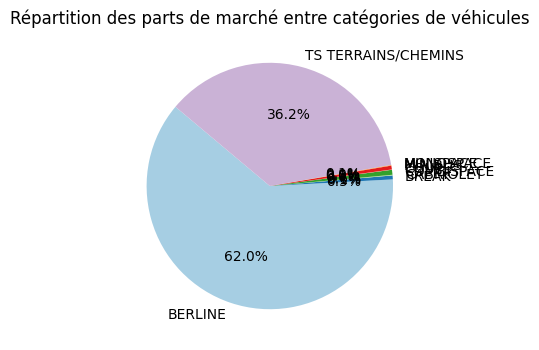

Dans la vraie vie


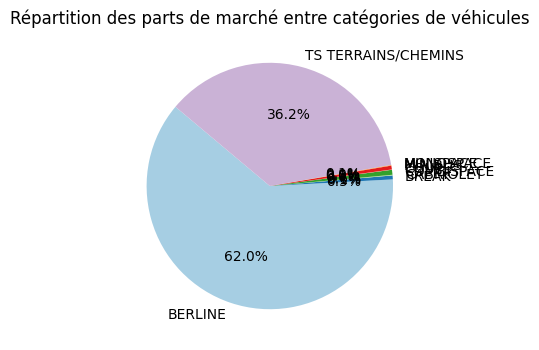

+---------------------+-------------------------+---------------------------------+
| Categorie           |   Part de marché réelle |   Part de marché (nested-logit) |
+=====================+=========================+=================================+
| BERLINE             |             0.619673    |                     0.619673    |
+---------------------+-------------------------+---------------------------------+
| BREAK               |             0.00514563  |                     0.00514563  |
+---------------------+-------------------------+---------------------------------+
| CABRIOLET           |             0.000849278 |                     0.000849278 |
+---------------------+-------------------------+---------------------------------+
| COMBISPACE          |             0.00649448  |                     0.00649448  |
+---------------------+-------------------------+---------------------------------+
| COUPE               |             0.00039966  |                     0.0003

In [ ]:
#Affichage + debug

prix_reel= prix
prix_simul= prix
bonus_reel= bonus
bonus_simul= bonus


#Calcul des parts de marché par modele (réeles et simulées)
s_reel_mod = ventes[np.where(typ=='ELECTRIC')]/np.sum(ventes[np.where(typ=='ELECTRIC')])
s_simul_mod , sum = nested_logit_EV(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes)

#Calcul des part de marché par catégorie

    # Étape 1 : Convertir les catégories en indices numériques
categories_uniques, cat_indices = np.unique(cat[np.where(typ=='ELECTRIC')], return_inverse=True)
nb_categories = len(categories_uniques)

    # Étape 2 : Regrouper les probabilités par catégorie :
s_reel_cat = np.bincount(cat_indices, weights=s_reel_mod, minlength=nb_categories)
s_simul_cat = np.bincount(cat_indices, weights=s_simul_mod, minlength=nb_categories)

def pie_chart_parts_de_marches(s_cat,categories):
    """
    Prend en argument le resultat de parts_de_marches_cat.
    Affiche un diagramme circulaire de la répartition des parts de marché entre catégories de véhicules.
    """

    # Créer un diagramme circulaire
    plt.figure(figsize=(4, 4))  # Taille de la figure
    plt.pie(s_cat, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

    # Ajouter un titre
    plt.title("Répartition des parts de marché entre catégories de véhicules")

    # Afficher le diagramme
    plt.show()

print("Nested Logit Results : ")
pie_chart_parts_de_marches(s_simul_cat,categories_uniques)
print("Dans la vraie vie")
pie_chart_parts_de_marches(s_reel_cat,categories_uniques)

#Affichage tableau
data = np.empty((1+len(categories_uniques), 3), dtype=object)
data[0]=["Categorie","Part de marché réelle","Part de marché (nested-logit)"]
for i in range(len(categories_uniques)):
  data[i+1]=[categories_uniques[i],s_reel_cat[i],s_simul_cat[i]]
print(tabulate(data, headers="firstrow", tablefmt="grid"))


### Cas marché non éléctrique

Nested Logit Results : 


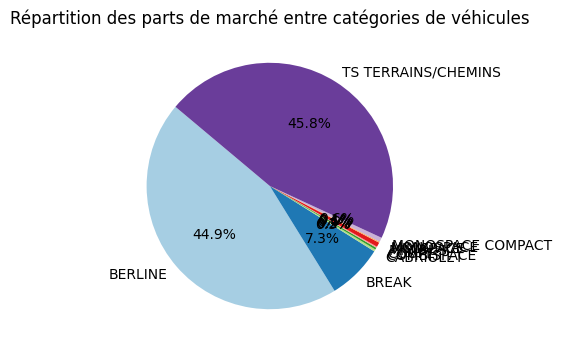

Dans la vraie vie


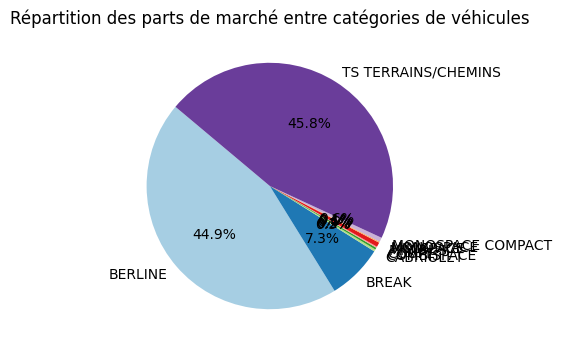

+---------------------+-------------------------+---------------------------------+
| Categorie           |   Part de marché réelle |   Part de marché (nested-logit) |
+=====================+=========================+=================================+
| BERLINE             |             0.449216    |                     0.449216    |
+---------------------+-------------------------+---------------------------------+
| BREAK               |             0.0729561   |                     0.0729561   |
+---------------------+-------------------------+---------------------------------+
| CABRIOLET           |             0.00274771  |                     0.00274771  |
+---------------------+-------------------------+---------------------------------+
| COMBISPACE          |             0.0025717   |                     0.0025717   |
+---------------------+-------------------------+---------------------------------+
| COUPE               |             0.00158409  |                     0.0015

In [ ]:
#Affichage + debug

bonus_reel= bonus
bonus_simul= bonus
prix_reel= prix
prix_simul= prix



#Calcul des parts de marché par modele (réeles et simulées)
s_reel_mod = ventes[np.where(typ!='ELECTRIC')]/np.sum(ventes[np.where(typ!='ELECTRIC')])
s_simul_mod , sum = nested_logit_ICE(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes)

#Calcul des part de marché par catégorie

    # Étape 1 : Convertir les catégories en indices numériques
categories_uniques, cat_indices = np.unique(cat[np.where(typ!='ELECTRIC')], return_inverse=True)
nb_categories = len(categories_uniques)

    # Étape 2 : Regrouper les probabilités par catégorie :
s_reel_cat = np.bincount(cat_indices, weights=s_reel_mod, minlength=nb_categories)
s_simul_cat = np.bincount(cat_indices, weights=s_simul_mod, minlength=nb_categories)

def pie_chart_parts_de_marches(s_cat,categories):
    """
    Prend en argument le resultat de parts_de_marches_cat.
    Affiche un diagramme circulaire de la répartition des parts de marché entre catégories de véhicules.
    """

    # Créer un diagramme circulaire
    plt.figure(figsize=(4, 4))  # Taille de la figure
    plt.pie(s_cat, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

    # Ajouter un titre
    plt.title("Répartition des parts de marché entre catégories de véhicules")

    # Afficher le diagramme
    plt.show()

print("Nested Logit Results : ")
pie_chart_parts_de_marches(s_simul_cat,categories_uniques)
print("Dans la vraie vie")
pie_chart_parts_de_marches(s_reel_cat,categories_uniques)

#Affichage tableau
data = np.empty((1+len(categories_uniques), 3), dtype=object)
data[0]=["Categorie","Part de marché réelle","Part de marché (nested-logit)"]
for i in range(len(categories_uniques)):
  data[i+1]=[categories_uniques[i],s_reel_cat[i],s_simul_cat[i]]
print(tabulate(data, headers="firstrow", tablefmt="grid"))


### Cas général

In [ ]:
#Definition des variables pas encore définie et nécessaires au nested logit

prix_reel= prix
prix_simul= prix
bonus_reel= bonus
bonus_simul= donnees_par_mois['2023-10-01']['bonus']


#Calcul des parts de marché par modele (réeles et simulées)
s_reel_mod = ventes/np.sum(ventes)
s_simul_mod = nested_logit(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes, alpha_ICE, alpha_EV, sigma_c, sigma_g)

#Calcul des part de marché par catégorie

    # Étape 1 : Convertir les catégories en indices numériques
categories_uniques, cat_indices = np.unique(cat, return_inverse=True)
nb_categories = len(categories_uniques)

    # Étape 2 : Regrouper les probabilités par catégorie :
s_reel_cat = np.bincount(cat_indices, weights=s_reel_mod, minlength=nb_categories)
s_simul_cat = np.bincount(cat_indices, weights=s_simul_mod, minlength=nb_categories)

#Affichage des résultats par catégorie

def pie_chart_parts_de_marches(s_cat,categories):
    """
    Prend en argument le resultat de parts_de_marches_cat.
    Affiche un diagramme circulaire de la répartition des parts de marché entre catégories de véhicules.
    """

    # Créer un diagramme circulaire
    plt.figure(figsize=(4, 4))  # Taille de la figure
    plt.pie(s_cat, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

    # Ajouter un titre
    plt.title("Répartition des parts de marché entre catégories de véhicules")

    # Afficher le diagramme
    plt.show()


#print("Nested Logit Results : ")
#pie_chart_parts_de_marches(s_simul_cat,categories_uniques)
#print("Dans la vraie vie")
#pie_chart_parts_de_marches(s_reel_cat,categories_uniques)

#Affichage tableau
data = np.empty((1+len(categories_uniques), 3), dtype=object)
data[0]=["Categorie","Part de marché réelle","Part de marché (nested-logit)"]
for i in range(len(categories_uniques)):
  data[i+1]=[categories_uniques[i],s_reel_cat[i],s_simul_cat[i]]
print(tabulate(data, headers="firstrow", tablefmt="grid"))

<ipython-input-7-343cea02e38b>:59: RuntimeWarning: invalid value encountered in divide
  s_EV = ventes_EV[np.where((cat_EV==categorie)) ]/np.sum(ventes_EV[np.where(cat_EV==categorie)]) #part de marché conditionnelle au sein du nest le plus bas
<ipython-input-7-343cea02e38b>:91: RuntimeWarning: invalid value encountered in scalar divide
  numerateur = (ventes[i]/total_ventes_EV[cat[i]])*np.exp(alpha_EV*(prix_simul[i]+bonus_simul[i]-prix_reel[i]-bonus_reel[i]))*P_EV[cat[i]]


+---------------------+-------------------------+---------------------------------+
| Categorie           |   Part de marché réelle |   Part de marché (nested-logit) |
+=====================+=========================+=================================+
| BERLINE             |             0.466031    |                             nan |
+---------------------+-------------------------+---------------------------------+
| BREAK               |             0.0545654   |                             nan |
+---------------------+-------------------------+---------------------------------+
| CABRIOLET           |             0.00217976  |                             nan |
+---------------------+-------------------------+---------------------------------+
| COMBISPACE          |             0.00673581  |                             nan |
+---------------------+-------------------------+---------------------------------+
| COUPE               |             0.00206362  |                           

## 2ème cas : comparaison de 2 réformes

Objectif : visualiser sur un même graphique l’évolution :

- des parts de marché réelles des différentes catégories de véhicules (SUV, berlines, etc.) et/ou des types de motorisation (électrique, thermique, etc.)

- des parts de marché simulées dans un scénario contrefactuel, c’est-à-dire si la réforme précédente (en vigueur à t) avait été maintenue au temps t+1, au lieu d’appliquer la nouvelle réforme réelle mise en place à ce moment-là.

L’idée est donc de comparer l’impact des deux politiques (ancienne vs nouvelle) sur la structure du marché.

Nested Logit Results : 


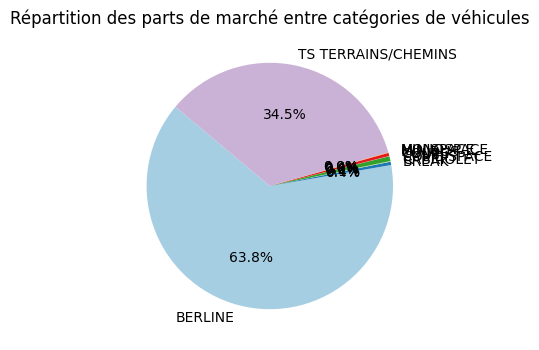

Dans la vraie vie


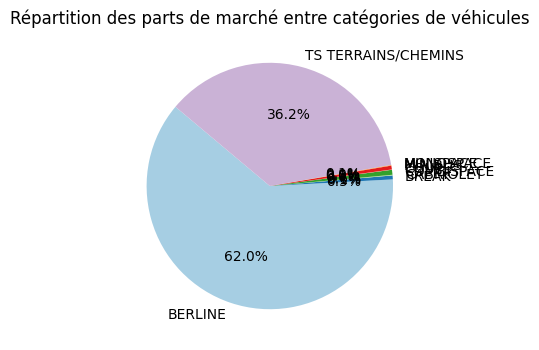

+---------------------+-------------------------+---------------------------------+
| Categorie           |   Part de marché réelle |   Part de marché (nested-logit) |
+=====================+=========================+=================================+
| BERLINE             |             0.619673    |                     0.63788     |
+---------------------+-------------------------+---------------------------------+
| BREAK               |             0.00514563  |                     0.00433943  |
+---------------------+-------------------------+---------------------------------+
| CABRIOLET           |             0.000849278 |                     0.000889606 |
+---------------------+-------------------------+---------------------------------+
| COMBISPACE          |             0.00649448  |                     0.00634958  |
+---------------------+-------------------------+---------------------------------+
| COUPE               |             0.00039966  |                     0.0003

In [ ]:
#Affichage + debug

prix_reel= prix
prix_simul= prix
bonus_reel= bonus
bonus_simul= np.zeros(len(bonus))
#bonus_simul= nouveau_bonus


#Calcul des parts de marché par modele (réeles et simulées)
s_reel_mod = ventes[np.where(typ=='ELECTRIC')]/np.sum(ventes[np.where(typ=='ELECTRIC')])
s_simul_mod , sum = nested_logit_EV(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes)

#Calcul des part de marché par catégorie

    # Étape 1 : Convertir les catégories en indices numériques
categories_uniques, cat_indices = np.unique(cat[np.where(typ=='ELECTRIC')], return_inverse=True)
nb_categories = len(categories_uniques)

    # Étape 2 : Regrouper les probabilités par catégorie :
s_reel_cat = np.bincount(cat_indices, weights=s_reel_mod, minlength=nb_categories)
s_simul_cat = np.bincount(cat_indices, weights=s_simul_mod, minlength=nb_categories)

print("Nested Logit Results : ")
pie_chart_parts_de_marches(s_simul_cat,categories_uniques)
print("Dans la vraie vie")
pie_chart_parts_de_marches(s_reel_cat,categories_uniques)

#Affichage tableau
data = np.empty((1+len(categories_uniques), 3), dtype=object)
data[0]=["Categorie","Part de marché réelle","Part de marché (nested-logit)"]
for i in range(len(categories_uniques)):
  data[i+1]=[categories_uniques[i],s_reel_cat[i],s_simul_cat[i]]
print(tabulate(data, headers="firstrow", tablefmt="grid"))

#Détermination des incertitudes

On cherche à déterminer les incertitudes de ces valeurs. Les seuls variables déterminées arbitrairement sont celles liées aux paramètres sigma_c, sigma_g, alpha_ICE et alpha_EV qui sont représentatif des choix des consommateurs et de leurs préférences.

### V1 Monte-Carlo avec tout en meme temps

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm

alpha_ICE = -0.19
alpha_EV = -0.15
sigma_c = 0.495
sigma_g = 0.885

def sample_truncated_gaussian(mean, var, lower, upper):

  # Tirage aléatoire des paramètres autour de leur moyenne (variance 10%)
  std = np.sqrt(var)

  # Standardiser les bornes
  a_trunc = (lower - mean) / std
  b_trunc = (upper - mean) / std

  # Créer la distribution tronquée
  trunc_gauss = truncnorm(a_trunc, b_trunc, loc=mean, scale=std)

  # Tirer un échantillon
  return trunc_gauss.rvs()

def monte_carlo_nested_logit(mod, typ, marque, prix_reel, prix_simul, cat, bonusj_reel, bonus_simul, ventes,
                              alpha_ICE, alpha_EV, sigma_c, sigma_g, s_reel,
                              n_simulations, nested_logit_func):
    """
    Effectue une simulation Monte Carlo pour estimer les incertitudes sur les parts de marché
    dans un nested logit à partir de variations normales des paramètres.

    Retourne un DataFrame avec :
        - les modèles
        - la moyenne des parts simulées
        - l'incertitude (écart-type)
        - les parts de marché réelles (s_reel)
    """
    n = len(mod)
    all_simulations = np.zeros((n_simulations, n))

    for i in range(n_simulations):

        alpha_ICE_sim = sample_truncated_gaussian(alpha_ICE, 0.15 * abs(alpha_ICE), max(-0.99,1.5*alpha_ICE), 0.5*alpha_ICE)
        alpha_EV_sim = sample_truncated_gaussian(alpha_EV, 0.15 * abs(alpha_EV),max(-0.99,1.5*alpha_EV), 0.5*alpha_EV)
        sigma_c_sim = sample_truncated_gaussian(sigma_c, 0.15 * abs(sigma_c), 0.5*sigma_c, min(0.99,1.5*sigma_c))
        sigma_g_sim = sample_truncated_gaussian(sigma_g, 0.15* abs(sigma_g), 0.5*sigma_g, min(0.99,1.5*sigma_g))

        # Calcul des parts de marché simulées
        s_sim = nested_logit_func(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes, alpha_ICE_sim, alpha_EV_sim, sigma_c_sim, sigma_g_sim)

        all_simulations[i, :] = s_sim

    # Moyenne et écart-type des simulations
    s_mean = np.mean(all_simulations, axis=0)
    s_std = np.std(all_simulations, axis=0)
    print(s_std)
    # Résultat sous forme de dico
    result = {
        'Part_Marché_Moy': s_mean,
        "Part_nested": s_sim,
        'Incertitude_Part_Marché': s_std,
        'Part_Marché_Réelle': ventes/np.sum(ventes)
    }

    return result

In [ ]:
resultats = monte_carlo_nested_logit(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes, alpha_ICE, alpha_EV, sigma_c, sigma_g, s_reel_mod, 100, nested_logit)

<ipython-input-3-ebe70646c020>:74: RuntimeWarning: overflow encountered in scalar power
  delta_EV = np.sum([P_EV[c]*(sum_EV[c]**(1/(1-sigma_g))) for c in sum_EV])
<ipython-input-3-ebe70646c020>:97: RuntimeWarning: invalid value encountered in scalar multiply
  numerateur = numerateur * P["EV"] * (delta_EV**(1-sigma_g))
<ipython-input-3-ebe70646c020>:102: RuntimeWarning: invalid value encountered in scalar divide
  s_simul[i] = numerateur/denominateur


[nan nan nan ...  0.  0.  0.]


## Calcul des parts de marché par catégories

In [ ]:
# Dictionnaire des catégories
CATEGORIES_DICT = {
    "BERLINE": 0, "BREAK": 0, "CABRIOLET": 0, "COMBISPACE": 0,
     "MINIBUS": 0, "MINISPACE": 0, "MONOSPACE": 0,
    "MONOSPACE COMPACT": 0, "TS TERRAINS/CHEMINS": 0
}

def calculer_parts_marche_par_categorie(
    dates, alpha_EV, alpha_ICE, sigma_g, sigma_c,
    nested_logit_func, N=10, save_path=None
):
    data = []
    categories = list(CATEGORIES_DICT.keys())

    for date in dates:
        mod, typ, marque, prix, cat, bonus, ventes = donnees_mois(date)

        prix_reel= prix
        prix_simul= prix
        bonus_reel= bonus
        bonus_simul= np.zeros(len(bonus))

        for categorie in CATEGORIES_DICT :
          masque_cat = (cat == categorie)
          masque_EV = (typ == 'ELECTRIC')
          masque_ICE = (typ != 'ELECTRIC')

          mod_cat_EV = mod[masque_cat & masque_EV]
          mod_cat_ICE = mod[masque_cat & masque_ICE]

          ventes_cat_EV = ventes[masque_cat & masque_EV]
          ventes_cat_ICE = ventes[masque_cat & masque_ICE]

          s_reel = np.sum(ventes) / np.sum(ventes)
          s_reel_EV = np.sum(ventes_cat_EV) / np.sum(ventes)
          s_reel_ICE = np.sum(ventes_cat_ICE) / np.sum(ventes)

          tab = monte_carlo_nested_logit(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes,
                              alpha_ICE, alpha_EV, sigma_c, sigma_g, s_reel,
                              N, nested_logit)

          part_monte_EV = np.sum(tab['Part_Marché_Moy'][masque_cat & masque_EV])
          part_monte_ICE = np.sum(tab['Part_Marché_Moy'][masque_cat & masque_ICE])

          incertitude_EV = np.sum(tab['Incertitude_Part_Marché'][masque_cat & masque_EV])
          incertitude_ICE = np.sum(tab['Incertitude_Part_Marché'][masque_cat & masque_ICE])

          part_nested_EV = np.sum(tab['Part_nested'][masque_cat & masque_EV])
          part_nested_ICE = np.sum(tab['Part_nested'][masque_cat & masque_ICE])


          data.append({
              "date": date,
              "categorie": categorie,
              "part_reelle": s_reel,
              "part_monte_carlo_EV": part_monte_EV,
              "part_monte_carlo_ICE": part_monte_ICE,

              "part_nested_EV": part_nested_EV,
              "part_nested_ICE": part_nested_ICE,

              "incertitude_EV": incertitude_EV,
              "incertitude_ICE": incertitude_ICE,
          })

    df_resultats = pd.DataFrame(data)

    if save_path:
        df_resultats.to_excel(save_path, index=False)

    return df_resultats

#Tracé des graphes

### V2 On trace par catéorie

In [ ]:
#dates = [f"2023-{mois:02d}-01" for mois in range(1, 13)] + [f"2024-{mois:02d}-01" for mois in range(1, 13)]
#dates = [f"2023-{mois:02d}-01" for mois in range(1, 13)]
dates =[f"2022-{mois:02d}-01" for mois in range(1, 2)]
categories = list(set(cat))

# Étape 1 : lancer et sauvegarder
df_parts = calculer_parts_marche_par_categorie(
    dates, alpha_EV, alpha_ICE, sigma_g, sigma_c,
    nested_logit_func=nested_logit,
    N=100,
    save_path="parts_par_categorie.xlsx"
)

# Étape 2 : tracer
#tracer_parts_par_categorie(df_parts)

<ipython-input-7-343cea02e38b>:59: RuntimeWarning: invalid value encountered in divide
  s_EV = ventes_EV[np.where((cat_EV==categorie)) ]/np.sum(ventes_EV[np.where(cat_EV==categorie)]) #part de marché conditionnelle au sein du nest le plus bas
<ipython-input-7-343cea02e38b>:91: RuntimeWarning: invalid value encountered in scalar divide
  numerateur = (ventes[i]/total_ventes_EV[cat[i]])*np.exp(alpha_EV*(prix_simul[i]+bonus_simul[i]-prix_reel[i]-bonus_reel[i]))*P_EV[cat[i]]


[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-7f4769f8af57>", line 7, in <cell line: 0>
    df_parts = calculer_parts_marche_par_categorie(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-32-72bab0561469>", line 38, in calculer_parts_marche_par_categorie
    tab = monte_carlo_nested_logit(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-9-3602e5e9ec5f>", line 49, in monte_carlo_nested_logit
    s_sim = nested_logit(mod, typ, marque, prix_reel, prix_simul, cat, bonus_reel, bonus_simul, ventes, alpha_ICE_sim, alpha_EV_sim, sigma_c_sim, sigma_g_sim)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: object of type 'NoneType' has no len()